In [19]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [20]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

import warnings

warnings.filterwarnings("ignore")

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [23]:
# %env ROCKFISH_API_KEY=YOUR_API_KEY
# conn = rf.Connection.from_env()
conn = rf.Connection.from_config("staging")

In [22]:
# download our example of timeseries data: finance.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/finance.csv

File ‘finance.csv’ already there; not retrieving.



In [5]:
dataset = rf.Dataset.from_csv("finance", "finance.csv")
dataset.to_pandas()

,customer,age,gender,merchant,category,amount,fraud,timestamp
0,C1093826151,4,M,M348934600,transportation,4.55,0,2023-01-01
1,C575345520,2,F,M348934600,transportation,76.67,0,2023-01-01
2,C1787537369,2,M,M1823072687,transportation,48.02,0,2023-01-01
3,C1732307957,5,F,M348934600,transportation,55.06,0,2023-01-01
4,C842799656,1,F,M348934600,transportation,25.62,0,2023-01-01
...,...,...,...,...,...,...,...,...
49995,C1971105040,3,M,M348934600,transportation,67.91,0,2023-01-20
49996,C51444479,3,M,M348934600,transportation,32.27,0,2023-01-20
49997,C1096642744,5,M,M1535107174,wellnessandbeauty,149.70,0,2023-01-20
49998,C1166683343,2,F,M1823072687,transportation,24.78,0,2023-01-20


In [ ]:
train_config = ra.TrainTimeGAN.Config(
    encoder=ra.TrainTimeGAN.DatasetConfig(
        timestamp=ra.TrainTimeGAN.TimestampConfig(field="timestamp"),
        metadata=[
            ra.TrainTimeGAN.FieldConfig(field="customer", type="session"),
            ra.TrainTimeGAN.FieldConfig(field="age", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="gender", type="categorical"),
        ],
        measurements=[
            ra.TrainTimeGAN.FieldConfig(field="merchant", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="category", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="amount"),
            ra.TrainTimeGAN.FieldConfig(field="fraud", type="categorical"),
        ],
    ),
    doppelganger=ra.TrainTimeGAN.DGConfig(
        sample_len=19, epoch=10, epoch_checkpoint_freq=10, batch_size=64
    ),
)

# create train action
train = ra.TrainTimeGAN(train_config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 4mJNh4p7wrmsGXDvFcc4GQ


In [8]:
async for log in workflow.logs():
    print(log)

2025-02-27T19:36:53Z dataset-load: INFO Downloading dataset '4nZg7tS9SJBHyK7poak6U3'
2025-02-27T19:36:54Z dataset-load: INFO Downloaded dataset '4nZg7tS9SJBHyK7poak6U3' with 50000 rows
2025-02-27T19:37:01Z train-time-gan: INFO Starting DG training job
2025-02-27T19:37:14Z train-time-gan: INFO Epoch 1 completed.
2025-02-27T19:37:26Z train-time-gan: INFO Epoch 2 completed.
2025-02-27T19:37:38Z train-time-gan: INFO Epoch 3 completed.
2025-02-27T19:37:50Z train-time-gan: INFO Epoch 4 completed.
2025-02-27T19:38:02Z train-time-gan: INFO Epoch 5 completed.
2025-02-27T19:38:14Z train-time-gan: INFO Epoch 6 completed.
2025-02-27T19:38:26Z train-time-gan: INFO Epoch 7 completed.
2025-02-27T19:38:39Z train-time-gan: INFO Epoch 8 completed.
2025-02-27T19:38:51Z train-time-gan: INFO Epoch 9 completed.
2025-02-27T19:39:03Z train-time-gan: INFO Epoch 10 completed.
2025-02-27T19:39:05Z train-time-gan: INFO Training completed. Uploaded model 80f354d4-f542-11ef-bf1b-d27724d2d9bb


In [9]:
model = await workflow.models().last()
model

Model(id='80f354d4-f542-11ef-bf1b-d27724d2d9bb', labels={'workflow_id': '4mJNh4p7wrmsGXDvFcc4GQ'}, create_time=datetime.datetime(2025, 2, 27, 19, 39, 5, tzinfo=datetime.timezone.utc), size_bytes=19994624)

In [ ]:
generate_config = ra.GenerateTimeGAN.Config(
    doppelganger=ra.GenerateTimeGAN.DGConfig()
)
generate = ra.GenerateTimeGAN(generate_config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(
    target=None
)  # users can assign a value to `target` parameter. Otherwise, it will generate the same number of sessions as the training dataset.
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)

In [11]:
async for log in workflow.logs():
    print(log)

2025-02-27T19:39:18Z generate-time-gan: INFO Downloading model with model_id='80f354d4-f542-11ef-bf1b-d27724d2d9bb'...
2025-02-27T19:39:20Z generate-time-gan: INFO Generating 1000 sessions...
2025-02-27T19:39:21Z session-target: INFO Grouping on: ['session_key']
2025-02-27T19:39:21Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-27T19:39:21Z session-target: INFO new=1000 total=1000 needs=2765
2025-02-27T19:39:21Z generate-time-gan: INFO Model found in cache
2025-02-27T19:39:21Z generate-time-gan: INFO Generating 1000 sessions...
2025-02-27T19:39:21Z dataset-save: INFO Saved dataset '1NIHH8A6Qb4AtL26F3wkjm' with 14776 rows
2025-02-27T19:39:22Z session-target: INFO Grouping on: ['session_key']
2025-02-27T19:39:23Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-27T19:39:23Z session-target: INFO new=1000 total=2000 needs=1765
2025-02-27T19:39:23Z generate-time-gan: INFO Model found in cache
2025-02-27T19:39:23Z generate-time-gan: INFO

In [12]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,age,gender,merchant,category,amount,fraud,timestamp,session_key
0,2,F,M1535107174,transportation,147.651894,0,2023-01-02 01:47:37,0.0
1,2,F,M1823072687,transportation,85.715193,0,2023-01-02 22:58:11,0.0
2,2,F,M1823072687,transportation,90.154814,0,2023-01-03 19:31:32,0.0
3,2,F,M348934600,transportation,112.860714,0,2023-01-04 14:59:26,0.0
4,2,F,M348934600,transportation,103.821378,0,2023-01-05 12:48:16,0.0
...,...,...,...,...,...,...,...,...
55251,1,M,M1600850729,transportation,75.309316,0,2023-01-03 12:24:06,3764.0
55252,1,M,M1823072687,transportation,70.183167,1,2023-01-04 08:14:26,3764.0
55253,1,M,M1823072687,transportation,80.280439,0,2023-01-05 04:37:17,3764.0
55254,1,M,M855959430,transportation,60.530574,0,2023-01-05 22:23:33,3764.0


### Evaluation


In [13]:
# assign metadata fields or session_key to both datasets in order to compute
# session related metrics
dataset = dataset.with_table_metadata(
    rf.TableMetadata(metadata=["customer", "age", "gender"])
)
syn = syn.with_table_metadata(rf.TableMetadata(metadata=["session_key"]))

**1. session length**


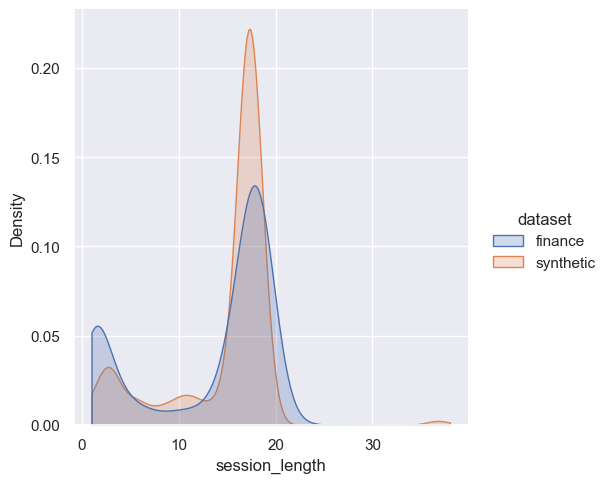

In [14]:
source_sess = rf.metrics.session_length(dataset)
syn_sess = rf.metrics.session_length(syn)
rf.labs.vis.plot_kde([source_sess, syn_sess], "session_length")

**2. interarrival time**

Here the unit for duration is in seconds


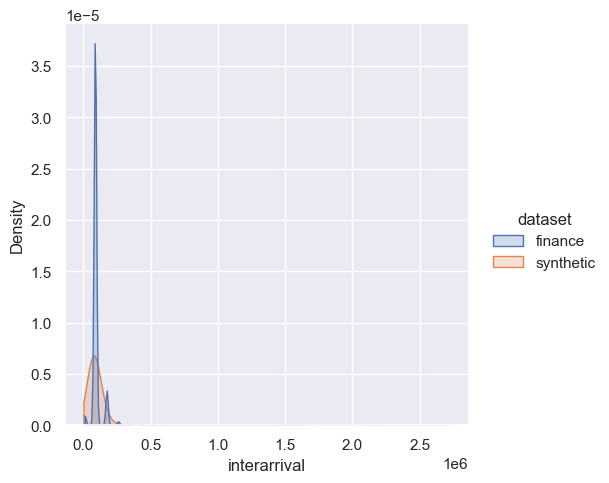

In [15]:
timestamp = "timestamp"
source_interarrival = rf.metrics.interarrivals(dataset, timestamp)
syn_interarrival = rf.metrics.interarrivals(syn, timestamp)
rf.labs.vis.plot_kde(
    [source_interarrival, syn_interarrival], "interarrival", duration_unit="s"
)

**3. numerical columns**


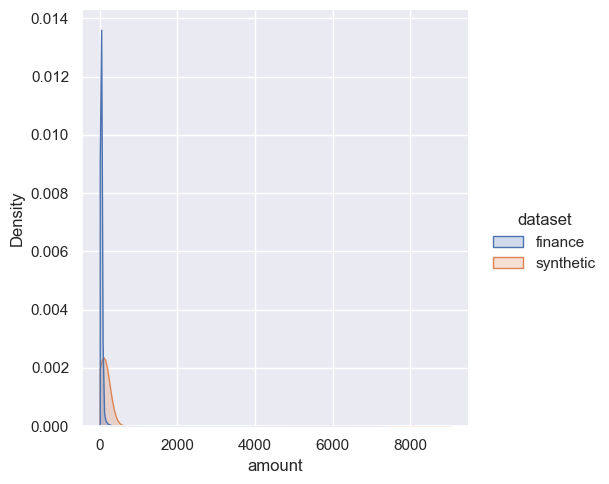

In [16]:
rf.labs.vis.plot_kde([dataset, syn], "amount")

**4. categorical columns**

If there is a large categorical column containing over 10 categories, we plot the Top10 bars for users to compare.

NB. If you want to show more than Top10, update the number of `nlargest`


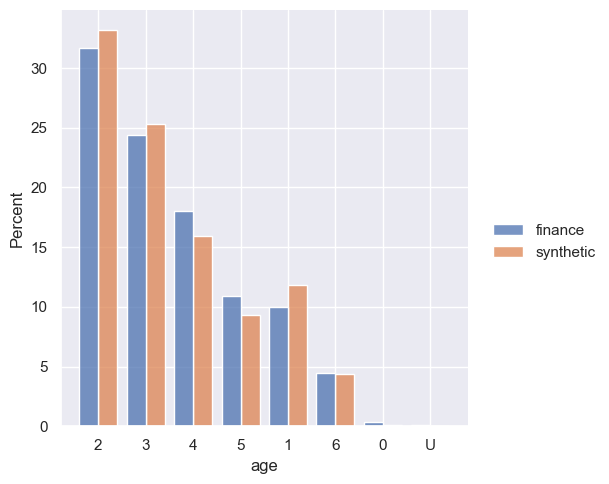

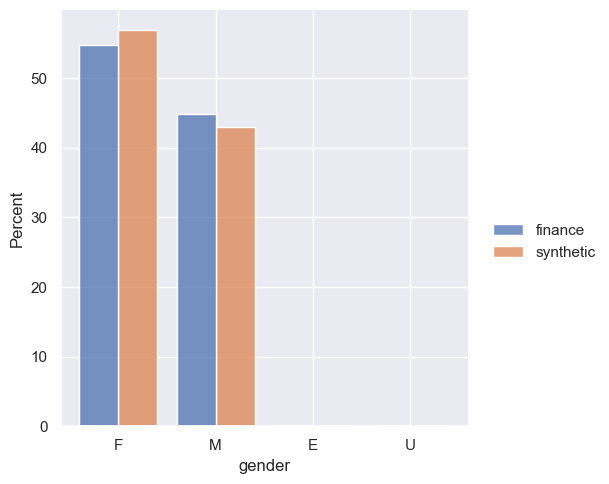

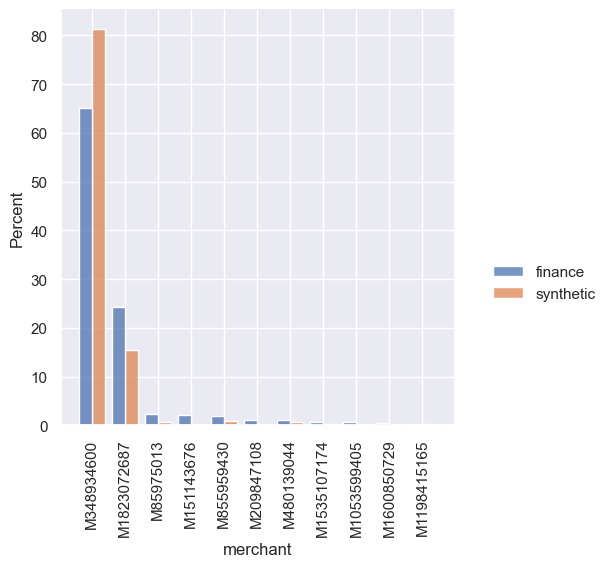

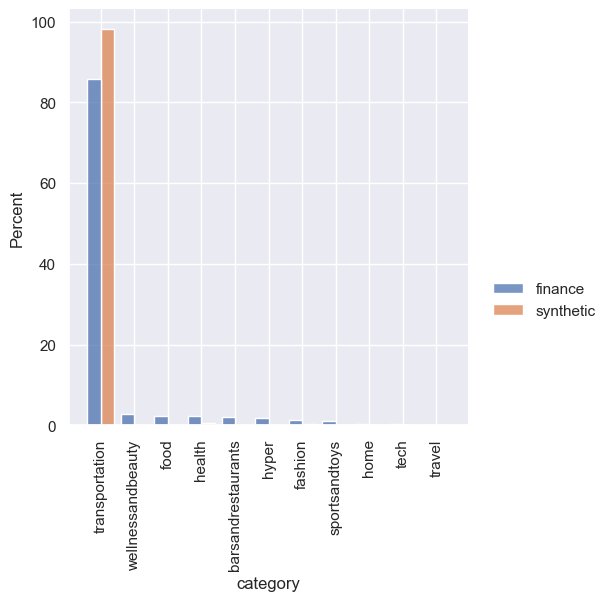

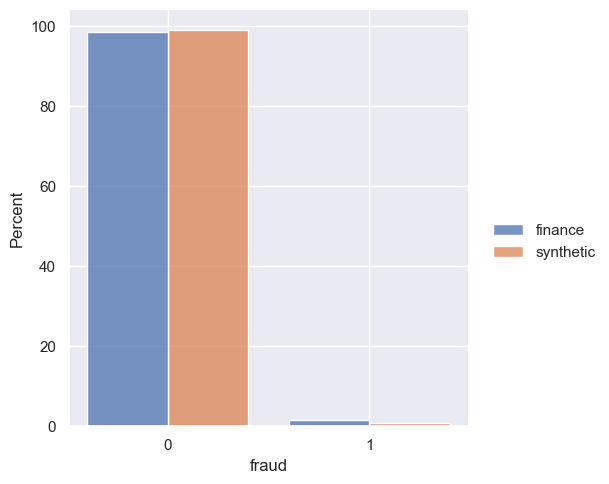

In [17]:
for col in ["age", "gender", "merchant", "category", "fraud"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")